# **Deep Learning (CNN & GANs)**

## **Project: Artworks Generation and Prediction**

## **Introduction**

In this project, We'll build two deep learning algorithms on a dataset of Artworks for the most famous artists, which are CNN and GAN. The goal is to generate new images of Artworks that look as realistic as possible. Also, predict the artwork belongs to which artist.

We'll divide the project into two sections, **Artworks Generation** and **Artworks Prediction**.

Artworks Generation section will be broken down into a series of tasks from loading in data to defining and training adversarial networks. At the end of the notebook, visualize the results of the trained Generator to see how it performs; the generated samples should look like fairly realistic artworks with small amounts of noise.

## **About the dataset**

The dataset is called **Best Artworks of All Time**, and was downloaded from **Kaggle**, and contains a collection of paintings of the 50 most influential artists of all time.

This dataset is more complex than the number datasets (like MNIST or SVHN) that we usually work with, and so, it needs deeper networks and training them for a longer time to get good results.

You can find and download the dataset from [here](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)



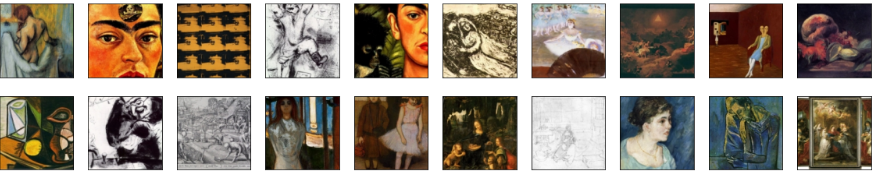

# **Section 1:  Artworks Generation**

## **Part 1:  Data Preprocessing**

### Import libraries and load the dataset

In [52]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread, mpimg
import seaborn as sns
import os
import shutil
from glob import glob
import pathlib
import pickle as pkl
import problem_unittests as tests

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

import tensorflow 
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline



data_dir = 'archive/resized/resized/pictures/'

### Create a data loader to view images

In [54]:
def get_dataloader(batch_size, image_size, data_dir='archive/resized/resized/pictures/'):
    
    transform =  transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    data_train = datasets.ImageFolder(data_dir, transform = transform)
    
    train_loader = torch.utils.data.DataLoader(dataset = data_train, batch_size = batch_size, shuffle = True, num_workers = 0)
    

    return train_loader

In [55]:
batch_size = 48
img_size = 32

art_train_loader = get_dataloader(batch_size, img_size)

### Convert images into a NumPy type and transpose the dimensions to correctly display an image

C:\Users\Majed\anaconda3\envs\directml\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


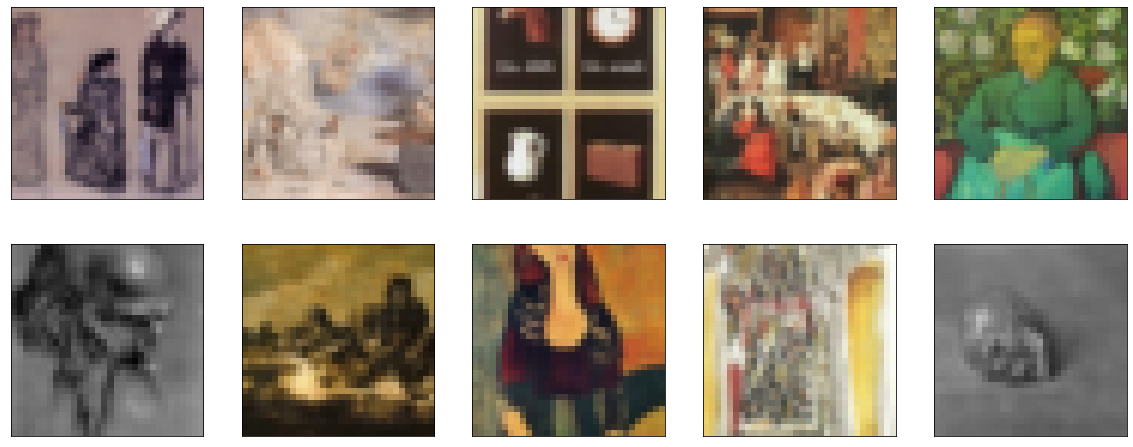

In [56]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(art_train_loader)
images, _ = dataiter.next()

fig = plt.figure(figsize=(20, 8))
plot_size=10
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Scale the images to a pixel range of -1 to 1

The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0 to 1)

In [57]:
def scale(x, feature_range=(-1, 1)):
   
    min, max = feature_range
    
    x = x * (max - min) + min   # min = -1, max = 1   =>  x = x * (2) - 1
    
    return x

In [58]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.6549)


---

## **Part 2:  Modeling**

### Define the Model

**GANs** are comprised of two adversarial networks, which are discriminator and generator.

**Discriminator**: This is a convolutional classifier, only without any max-pooling layers. To deal with this complex data, a deep network with **normalization** is used.

**Generator**: should upsample an input and generate a *new* image of the same size as our training data. This should be mostly transposed convolutional layers with normalization applied to the outputs.

In [60]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    conv_layer = nn.Conv2d( in_channels, out_channels, kernel_size, stride, padding, bias = False )

    layers.append( conv_layer )

    if batch_norm:
        layers.append( nn.BatchNorm2d(out_channels) )

    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim):
  
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        self.conv1 = conv(3, conv_dim, kernel_size = 4, batch_norm=False)

        self.conv2 = conv(conv_dim, conv_dim * 2, kernel_size = 4)

        self.conv3 = conv(conv_dim*2, conv_dim * 4, kernel_size = 4)

        self.fc = nn.Linear(conv_dim * 4 * 4 * 4, 1)
        

    def forward(self, x):

        out_layer = F.leaky_relu(self.conv1(x), 0.2)
        
        out_layer = F.leaky_relu(self.conv2(out_layer), 0.2)
        
        out_layer = F.leaky_relu(self.conv3(out_layer), 0.2)

        out_layer = out_layer.view(-1, self.conv_dim * 4 * 4 * 4)

        out_layer = self.fc(out_layer)        
        
        return out_layer
        


tests.test_discriminator(Discriminator)

Tests Passed


In [61]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    
    transpose_conv_layer = nn.ConvTranspose2d( in_channels, out_channels, kernel_size, stride, padding, bias = False )

    layers.append( transpose_conv_layer )
    
    if batch_norm:
        layers.append( nn.BatchNorm2d(out_channels) )
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):

        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)

        self.t_conv1 = deconv(conv_dim * 4, conv_dim * 2, 4)
        
        self.t_conv2 = deconv(conv_dim * 2, conv_dim, 4)
        
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm = False)
        

    def forward(self, x):
  
        out_layer = self.fc(x)
        
        out_layer = out_layer.view(-1, self.conv_dim * 4, 4, 4)

        out_layer = F.relu(self.t_conv1(out_layer))
        
        out_layer = F.relu(self.t_conv2(out_layer))

        out_layer = self.t_conv3(out_layer)
        
        out_layer = F.tanh(out_layer)
        
        return out_layer


tests.test_generator(Generator)

Tests Passed


C:\Users\Majed\anaconda3\envs\directml\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Initialize the weights of networks

In [62]:
def weights_init_normal(m):

    classname = m.__class__.__name__
    
    if hasattr(m, 'weight')  and  (classname.find( 'Conv' ) != -1  or  classname.find( 'Linear' ) != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m.bias, 'data'):
            nn.init.constant_(m.bias.data, 0.0)


In [63]:
def build_network(d_conv_dim, g_conv_dim, z_size):

    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


### Define model hyperparameters

In [64]:
d_conv_dim = 128

g_conv_dim = 128

z_size = 100


D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Discriminator and Generator Losses

**Discriminator Losses:** the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

**generator loss:** will look similar only with flipped labels. The generator's goal is to get the discriminator to think its generated images are real.

In [66]:
def real_loss(D_out):
   
    batch_size = D_out.size(0)

    labels = torch.ones( batch_size ) * 0.9
  
    if train_on_gpu:
        labels = labels.cuda()
        

    criterion = nn.BCEWithLogitsLoss()

    loss = criterion( D_out.squeeze(), labels )
    
    
    return loss


def fake_loss(D_out):
    
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros( batch_size ) 
    
    if train_on_gpu:
        labels = labels.cuda()
    
    
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion( D_out.squeeze(), labels )

    
    return loss

### Define Optimizers

In [67]:
lr = 0.0001

d_optimizer = optim.Adam(D.parameters(), lr, [ 0.3, 0.999 ])

g_optimizer = optim.Adam(G.parameters(), lr, [ 0.3, 0.999 ])

### Training the model

In [68]:
def train(D, G, n_epochs, print_every=50):

    if train_on_gpu:
        D.cuda()
        G.cuda()


    samples = []

    losses = []

    sample_size = 16
    
    fixed_z = np.random.uniform(-1, 1, size = ( sample_size, z_size ))
    
    fixed_z = torch.from_numpy( fixed_z ).float()

    if train_on_gpu:
        fixed_z = fixed_z.cuda()


    for epoch in range( n_epochs ):

        for batch_i, (real_images, _) in enumerate( art_train_loader ):

            batch_size = real_images.size(0)
            
            real_images = scale( real_images )

            
            d_optimizer.zero_grad()

            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D( real_images )
            
            d_real_loss = real_loss( D_real )

            z = np.random.uniform(-1, 1, size = ( batch_size, z_size ))
            
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
           
            D_fake = D( fake_images )
            
            d_fake_loss = fake_loss( D_fake )

            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            
            d_optimizer.step()
            
            
            
            g_optimizer.zero_grad()

            z = np.random.uniform(-1, 1, size=( batch_size, z_size ))
            
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)

            D_fake = D( fake_images )

            g_loss = real_loss( D_fake )

            g_loss.backward()
                                  
            g_optimizer.step()
            

            if batch_i % print_every == 0:

                losses.append((d_loss.item(), g_loss.item()))

                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format( epoch+1, n_epochs, d_loss.item(), g_loss.item() ))


        G.eval() 
        with torch.no_grad():
            samples_z = G( fixed_z )
            samples_z = samples_z.detach().cpu()
            samples.append( samples_z )
        G.train()

    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    

    return losses

In [69]:
tensorflow.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:DML:0', device_type='DML')]

Set your number of training epochs and train your GAN!

In [70]:
n_epochs = 10

losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.6035 | g_loss: 1.3404
Epoch [    1/   10] | d_loss: 0.5333 | g_loss: 3.3571
Epoch [    1/   10] | d_loss: 1.7073 | g_loss: 2.8005
Epoch [    1/   10] | d_loss: 0.7313 | g_loss: 3.6540
Epoch [    2/   10] | d_loss: 0.4536 | g_loss: 4.4865
Epoch [    2/   10] | d_loss: 1.0660 | g_loss: 3.0771
Epoch [    2/   10] | d_loss: 0.9155 | g_loss: 1.9409
Epoch [    2/   10] | d_loss: 0.9996 | g_loss: 1.8800
Epoch [    3/   10] | d_loss: 0.9148 | g_loss: 2.9396
Epoch [    3/   10] | d_loss: 0.8439 | g_loss: 2.8882
Epoch [    3/   10] | d_loss: 0.9870 | g_loss: 1.2685
Epoch [    3/   10] | d_loss: 0.6952 | g_loss: 2.7028
Epoch [    4/   10] | d_loss: 2.9061 | g_loss: 1.8079
Epoch [    4/   10] | d_loss: 0.5040 | g_loss: 2.6748
Epoch [    4/   10] | d_loss: 0.9387 | g_loss: 2.2725
Epoch [    4/   10] | d_loss: 0.6719 | g_loss: 3.3299
Epoch [    5/   10] | d_loss: 0.5496 | g_loss: 3.0234
Epoch [    5/   10] | d_loss: 0.9510 | g_loss: 2.9747
Epoch [    5/   10] | d_loss

### Training loss

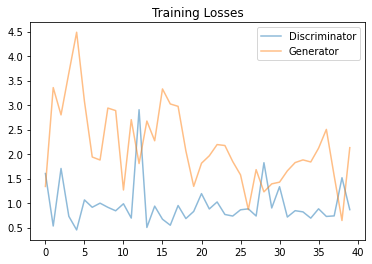

In [71]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha = 0.5)
plt.plot(losses.T[1], label='Generator', alpha = 0.5)
plt.title("Training Losses")
plt.legend()

### Generate samples from training

In [72]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots( figsize = (16, 4), nrows = 2, ncols = 5, sharey = True, sharex = True)
    
    for ax, img in zip( axes.flatten(), samples[epoch] ):
        
        img = img.detach().cpu().numpy()
        
        img = np.transpose(img, (1, 2, 0))
                
        img = ((img + 1) * 255 / (2)).astype(np.uint8)
        
        ax.xaxis.set_visible( False )
        
        ax.yaxis.set_visible( False )
        
        im = ax.imshow(img.reshape((32,32,3)))

In [73]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

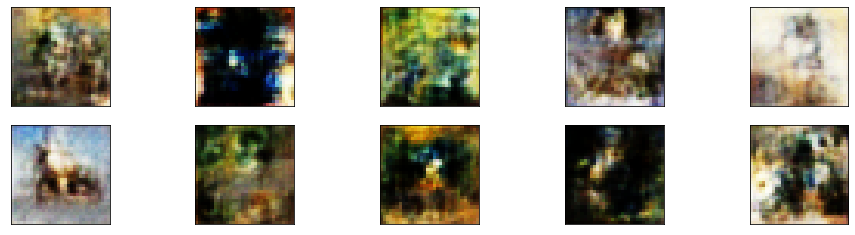

In [74]:
_ = view_samples(-1, samples)

---

# **Section 2:  Artworks Prediction**

## **Part 1:  Data Preprocessing**

### Load the dataset

**Note:**

In this section, the number of artists has been reduced to 10, due to the similarity in some artworks between artists, and also some artists do not have artworks that distinguish them from others.

In [2]:
for dirname, _, filenames in os.walk('Dataset_CNN/Dataset_CNN/art/train/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_10.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_100.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_101.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_102.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_103.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_104.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_105.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_106.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_107.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_108.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_109.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_11.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_110.jpg
Dataset_CNN/Dataset_CNN/art/train/Alfred_Sisley\Alfred_Sisley_112.jpg
Dataset_CNN/Dataset_CN

### View artworks samples by some artists

In [3]:
def plotImages(artist,directory):
    print(artist)
    multipleImages = glob(directory)
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:25]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1

Giottodi Bondone


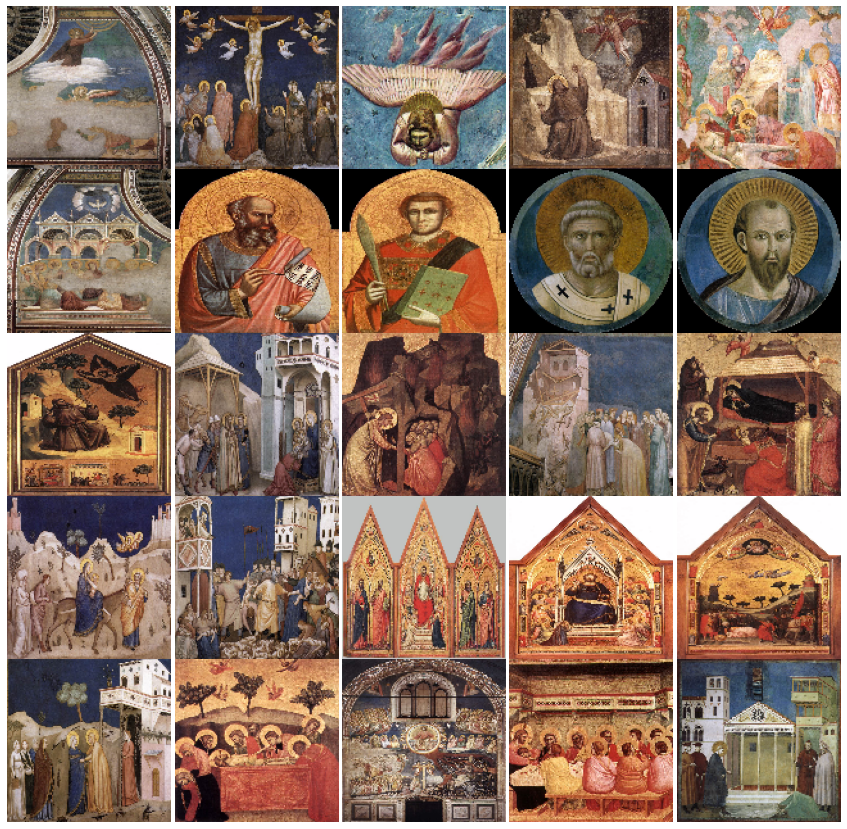

In [9]:
plotImages("Giottodi Bondone","Dataset_CNN/Dataset_CNN/art/train/Giotto_di_Bondone/**")      

Salvador Dali


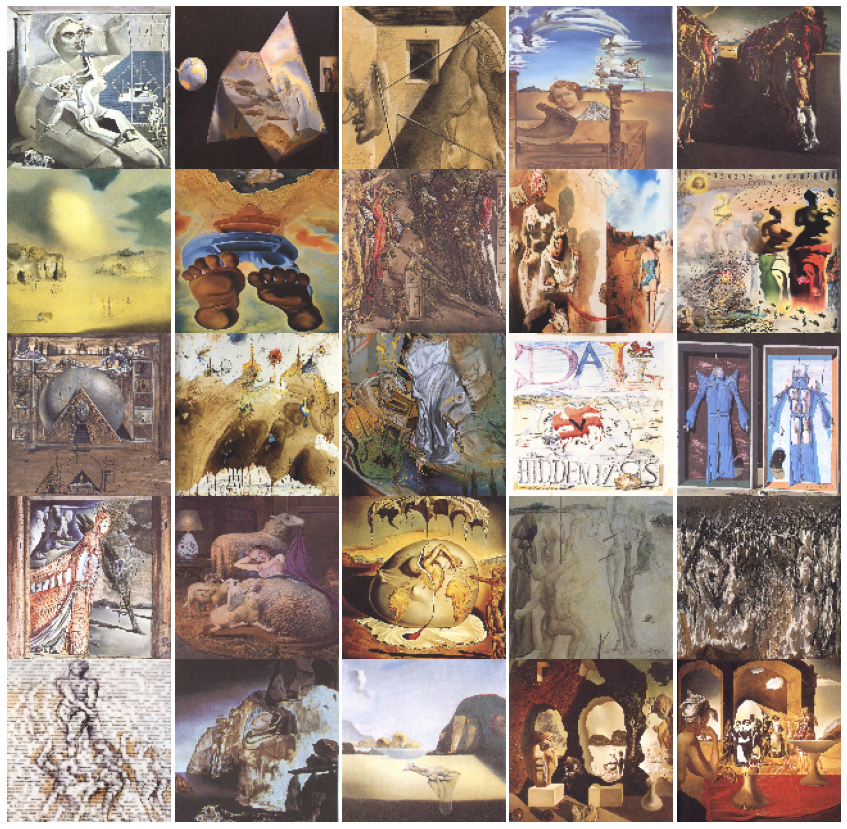

In [5]:
plotImages("Salvador Dali","Dataset_CNN/Dataset_CNN/art/train/Salvador_Dali/**")     

Rembrandt


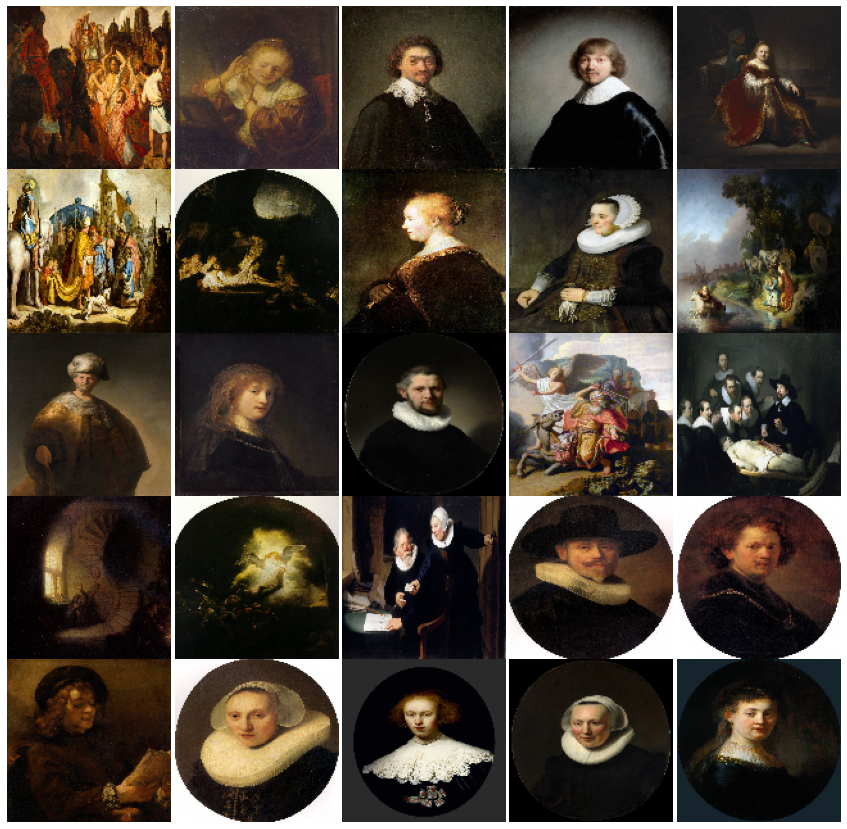

In [6]:
plotImages("Rembrandt","Dataset_CNN/Dataset_CNN/art/train/Rembrandt/**")  

### Preprocessing the Training set

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 5,
                                   zoom_range = 0.8,
                                   horizontal_flip = True
                                  )


training_set = train_datagen.flow_from_directory('Dataset_CNN/Dataset_CNN/art/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1615 images belonging to 10 classes.


### Preprocessing the Test set

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   
                                  )

test_set = test_datagen.flow_from_directory('Dataset_CNN/Dataset_CNN/art/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 160 images belonging to 10 classes.


### Preprocessing the set that we will try the model on

In [12]:
pred_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   
                                  )

pred_set = pred_datagen.flow_from_directory('Dataset_CNN/Dataset_CNN/art/single_pred',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 184 images belonging to 5 classes.


---

## **Part 2:  Modeling**

### Define the Model

In [14]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units = 128, activation='relu'))

cnn.add(tf.keras.layers.Dense(units = 10, activation='softmax'))

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [16]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

best_model_file = 'Dataset_CNN/Dataset_CNN/art/CNN_aug_best_weights.h5'

best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)

In [17]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the Model

In [18]:
history = cnn.fit_generator(training_set,
                              validation_data=test_set,
                              epochs = 75,
                              callbacks=[reduce_lr,early_stop, best_model],
                              shuffle=True,
                              verbose=1)

Epoch 1/75
 5/51 [=>............................] - ETA: 6s - loss: 1.7327 - acc: 0.4250
Epoch 00001: val_acc improved from -inf to 0.42500, saving model to Dataset_CNN/Dataset_CNN/art/CNN_aug_best_weights.h5
51/51 [==============================] - 8s 149ms/step - loss: 2.0630 - acc: 0.2675 - val_loss: 1.7327 - val_acc: 0.4250
Epoch 2/75
 5/51 [=>............................] - ETA: 6s - loss: 1.4097 - acc: 0.5563
Epoch 00002: val_acc improved from 0.42500 to 0.55625, saving model to Dataset_CNN/Dataset_CNN/art/CNN_aug_best_weights.h5
51/51 [==============================] - 7s 137ms/step - loss: 1.6758 - acc: 0.4291 - val_loss: 1.4097 - val_acc: 0.5563
Epoch 3/75
 5/51 [=>............................] - ETA: 6s - loss: 1.3338 - acc: 0.5563
Epoch 00003: val_acc did not improve from 0.55625
51/51 [==============================] - 7s 136ms/step - loss: 1.4672 - acc: 0.5028 - val_loss: 1.3338 - val_acc: 0.5563
Epoch 4/75
 5/51 [=>............................] - ETA: 6s - loss: 1.2136 - 

Epoch 23/75
 5/51 [=>............................] - ETA: 6s - loss: 0.8087 - acc: 0.7688
Epoch 00023: val_acc improved from 0.75000 to 0.76875, saving model to Dataset_CNN/Dataset_CNN/art/CNN_aug_best_weights.h5
51/51 [==============================] - 7s 136ms/step - loss: 0.8673 - acc: 0.7065 - val_loss: 0.8087 - val_acc: 0.7688
Epoch 24/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7994 - acc: 0.7188
Epoch 00024: val_acc did not improve from 0.76875
51/51 [==============================] - 7s 137ms/step - loss: 0.8040 - acc: 0.7294 - val_loss: 0.7994 - val_acc: 0.7188
Epoch 25/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7164 - acc: 0.7812
Epoch 00025: val_acc improved from 0.76875 to 0.78125, saving model to Dataset_CNN/Dataset_CNN/art/CNN_aug_best_weights.h5
51/51 [==============================] - 7s 138ms/step - loss: 0.7736 - acc: 0.7319 - val_loss: 0.7164 - val_acc: 0.7812
Epoch 26/75
 5/51 [=>............................] - ETA: 6s - loss: 0.

Epoch 45/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7191 - acc: 0.8000
Epoch 00045: val_acc did not improve from 0.81250
51/51 [==============================] - 7s 137ms/step - loss: 0.4800 - acc: 0.8427 - val_loss: 0.7191 - val_acc: 0.8000
Epoch 46/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7277 - acc: 0.7937
Epoch 00046: val_acc did not improve from 0.81250
51/51 [==============================] - 7s 138ms/step - loss: 0.5011 - acc: 0.8291 - val_loss: 0.7277 - val_acc: 0.7937
Epoch 47/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7289 - acc: 0.7625
Epoch 00047: val_acc did not improve from 0.81250
51/51 [==============================] - 7s 139ms/step - loss: 0.5020 - acc: 0.8372 - val_loss: 0.7289 - val_acc: 0.7625
Epoch 48/75
 5/51 [=>............................] - ETA: 6s - loss: 0.7524 - acc: 0.7875
Epoch 00048: val_acc did not improve from 0.81250
51/51 [==============================] - 7s 137ms/step - loss: 0.5082 - acc: 

### Using sample to test the model

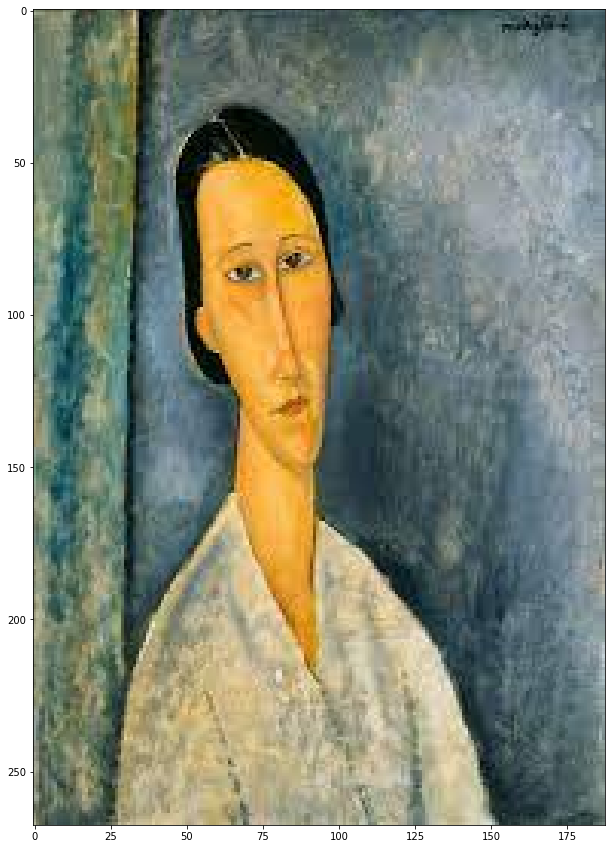

This Artwork belongs to Amedeo Modigliani Art


In [32]:
image_path = 'Dataset_CNN/Dataset_CNN/art/single_pred/AmedeoModiglianiArt.jpg'
test_image = image.load_img(image_path, target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

test_set.class_indices

if result[0][0] == 1:
  prediction = 'Alfred Sisley Art'
elif result[0][1] == 1:
  prediction = 'Amedeo Modigliani Art'
elif result[0][2] == 1:
  prediction = 'Frida Kahlo Art'
elif result[0][3] == 1:
  prediction = 'Giotto di Bondone Art'
# elif result[0][4] == 1:
#   prediction = 'Joan Miro Art'
elif result[0][4] == 1:
  prediction = 'Marc Chagall Art'
elif result[0][5] == 1:
  prediction = 'Paul Klee Art'
elif result[0][6] == 1:
  prediction = 'Piet Mondrian Art'
elif result[0][7] == 1:
  prediction = 'Rembrandt Art'
elif result[0][8] == 1:
  prediction = 'Rene Magritte Art'
else:
  prediction = 'Salvador Dali Art'

img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()


print(f"This Artwork belongs to {prediction}")

### Relationship between loss and number of epoch

Text(0.5, 1.0, 'Training and validation loss')

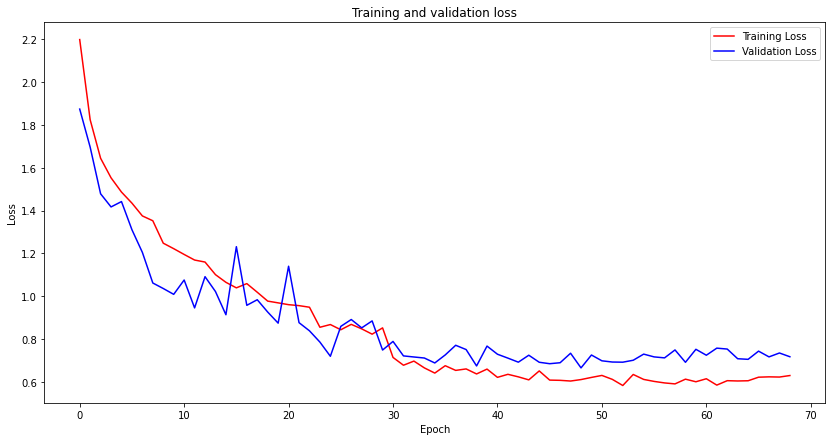

In [91]:
acc = history.history['acc']

val_acc = history.history['val_acc']

loss=history.history['loss']

val_loss=history.history['val_loss']

epochs=range(len(acc))

fig2 = plt.figure(figsize=(14,7))

plt.plot(epochs, loss, 'r', label="Training Loss")

plt.plot(epochs, val_loss, 'b', label="Validation Loss")

plt.legend(loc='upper right')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.title('Training and validation loss')

### Relationship between accuracy and number of epoch

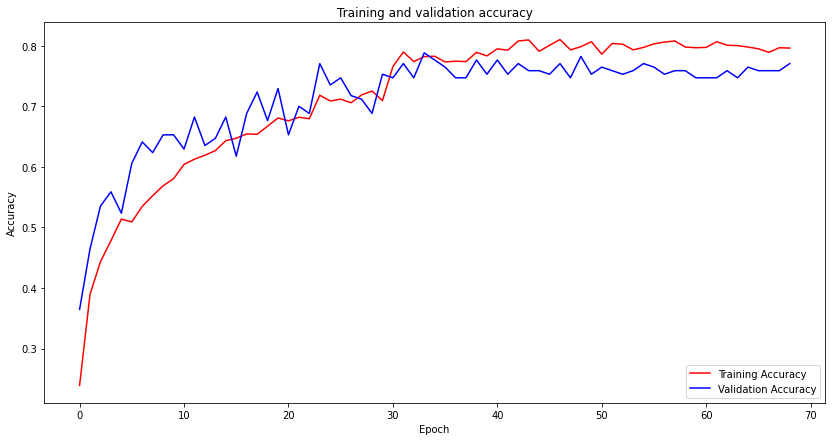

In [92]:
fig = plt.figure(figsize=(14,7))

plt.plot(epochs, acc, 'r', label="Training Accuracy")

plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')

plt.legend(loc='lower right')

plt.show()